### Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
import glob2
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

### Config from modules for ipynb

In [52]:
import ipynb
import importlib
import ipynb.fs.full.modules.Config as ipynb_config

In [56]:
importlib.reload(ipynb_config)

<module 'ipynb.fs.full.modules.Config' (/Users/dieumynguyen/Desktop/Projects/bee_communication_v2/ipynb/modules/Config.ipynb)>

In [57]:
X_MIN = ipynb_config.X_MIN
X_MAX = ipynb_config.X_MAX
DX = ipynb_config.DX
GRID_SIZE = np.arange(X_MIN, X_MAX+DX, DX).shape[0]
D = ipynb_config.DIFFUSION_COEFFICIENT
DECAY = ipynb_config.DECAY
T_MIN = ipynb_config.T_MIN
T_MAX = ipynb_config.T_MAX
DT = ipynb_config.DT
NUM_TIMESTEPS = np.arange(T_MIN, T_MAX+DT, DT).shape[0]
QUEEN_BEE_A = ipynb_config.QUEEN_INITIAL_CONCENTRATION
WORKER_BEE_A = ipynb_config.WORKER_INITIAL_CONCENTRATION
THRESHOLD = ipynb_config.WORKER_THRESHOLD
WB = ipynb_config.WORKER_BIAS_SCALAR
convert_xy_to_index = lambda xy: ((xy - X_MIN) / (X_MAX - X_MIN)) * GRID_SIZE

### Config from script 

In [82]:
def read_config(base_exp_dir):
    cfg_path = glob2.glob(f"{base_exp_dir}/*.cfg")[0]
    cfg_path, os.path.exists(cfg_path)

    with open(cfg_path, "r") as infile:
        lines = [line.split() for line in infile]
        cfg_opts = {}
        for key, val in lines:
            key = key.replace('--', '')

            try:
                val = float(val)
            except:
                try:
                    val = int(val)
                except:
                    if val.startswith("T"):
                        val = True
                    elif val.startswith("F"):
                        val = False
                    pass
            cfg_opts[key] = val
    return cfg_opts

In [83]:
base_exp_dir = "cfg__exp_015__2019-01-16_20-50-13"
script_config = read_config(base_exp_dir)
script_config

{'decay': 18.0,
 'diffusion_coefficient': 1.0,
 'dt': 0.05,
 'dx': 0.01,
 'enable_probabilistic': True,
 'measurements_on': True,
 'num_workers': 70.0,
 'queen_bias_scalar': 0.0,
 'queen_emission_frequency': 20.0,
 'queen_initial_concentration': 0.15,
 'queen_x': 0.0,
 'queen_y': 0.0,
 'random_seed': 80.0,
 'sensitivity_mode': 'none',
 'space_constraint': 0.85,
 't_max': 20.0,
 't_min': 0.0,
 't_threshold': 100.0,
 'verbose': True,
 'worker_bias_scalar': 5.0,
 'worker_initial_concentration': 0.15,
 'worker_step_size': 0.05,
 'worker_threshold': 1e-20,
 'worker_trans_prob': 0.0,
 'worker_wait_period': 20.0,
 'x_max': 3.0,
 'x_min': -3.0}

### Read h5 data & visualization

In [84]:
env_path = os.path.join(base_exp_dir, "envir_hist.h5")
bee_path = os.path.join(base_exp_dir, "bee_hist.h5")
os.path.exists(env_path), os.path.exists(bee_path), env_path

(True, True, 'cfg__exp_015__2019-01-16_20-50-13/envir_hist.h5')

- #### Concentration maps

In [35]:
with h5py.File(env_path, 'r') as infile:
    cmaps = np.array(infile['concentration'])

In [88]:
# Min and max concentrations for heatmap
min_c = np.min(cmaps)
max_c = np.max(cmaps)
min_c, max_c

(2.234795817749901e-40, 1.0246700907562236)

- #### Bee measurements

In [37]:
bee_data = {}
with h5py.File(bee_path, 'r') as infile:
    for key, val in infile.items():
        bee_data[key] = np.array(val)

In [39]:
bee_nums = np.unique(bee_data['bee_i'])
bees = {}
for bee_num in bee_nums:
    idxs = np.where(bee_data['bee_i']==bee_num)
    bee_x = bee_data['x'][idxs]
    bee_y = bee_data['y'][idxs]
    bee_state = bee_data['state'][idxs]
    distance = bee_data['distance_from_queen'][idxs]
    bee_grads = bee_data['gradient_x'][idxs], bee_data['gradient_y'][idxs]
    bias = bee_data['wx'][idxs], bee_data['wy'][idxs]
    bees[bee_num] = {"x" : bee_x, "y" : bee_y, "state": bee_state,
                    "distance": distance, "grads" : bee_grads}

### Make frames

In [21]:
colors = ["red", "gray", "#479030", "orange"]
color_decoder = {
    0: colors[1],
    1: colors[2],
    2: colors[2],
    3: colors[3]
}

Frame 34/400

KeyboardInterrupt: 

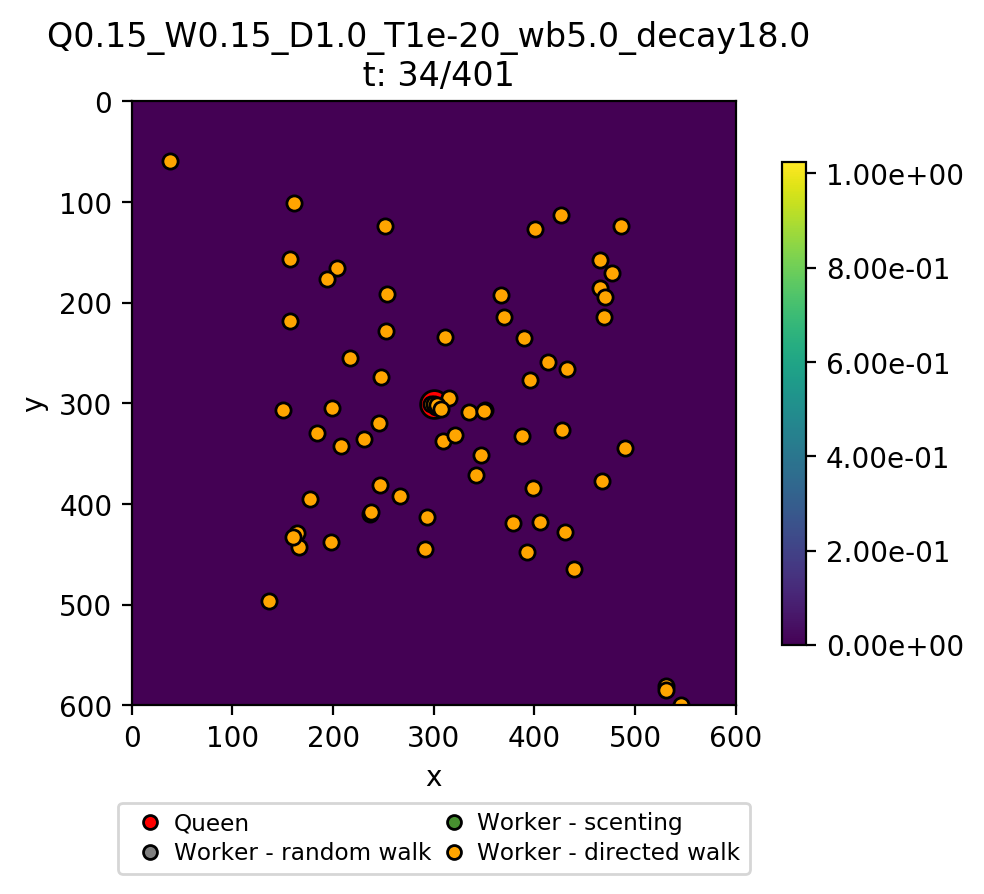

In [91]:
ipynb_config = False
for frame_i in range(cmaps.shape[0]):
    sys.stdout.write(f"\rFrame {frame_i+1}/{cmaps.shape[0]}")
    sys.stdout.flush()
    
    # CONCENTRATION
    cmap = cmaps[frame_i]
    plt.imshow(cmap, cmap='viridis', vmin=min_c, vmax=max_c)
    plt.colorbar(shrink=0.8, format='%.2e')  
    
    # QUEEN
    queen = convert_xy_to_index(0)
    plt.scatter(queen, queen, c="red", s=100, edgecolors='black', marker='o')     
    
    # WORKERS
    for bee_key, bee_vals in bees.items():
        x = bee_vals['x'][frame_i]
        y = bee_vals['y'][frame_i]
        state = bee_vals['state'][frame_i]
        color = color_decoder[state]
        plt.scatter(convert_xy_to_index(x), convert_xy_to_index(y), 
                    color=color, s=30, edgecolors='black')
        
    # FORMATTING
    texts = ["Queen", "Worker - random walk", "Worker - scenting", "Worker - directed walk"]
    patches = [ plt.plot([],[], marker="o", ms=5, ls="", mec=None, color=colors[i], 
                markeredgecolor="black", label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.22), 
               loc='center', ncol=2, numpoints=1, labelspacing=0.3,
               fontsize='small', fancybox="True",
               handletextpad=0, columnspacing=0)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(0, 600)
    plt.ylim(600, 0) 

    if ipynb_config:
        plt.title(f"Q{QUEEN_BEE_A}_W{WORKER_BEE_A}_D{D}_T{THRESHOLD}_wb{WB}_decay{DECAY} \n t: {frame_i+1}/{NUM_TIMESTEPS}")
    else:
        num_timesteps = np.arange(script_config['t_min'], script_config['t_max']+script_config['dt'], script_config['dt']).shape[0]
        plt.title(f"Q{script_config['queen_initial_concentration']}_W{script_config['worker_initial_concentration']}_D{script_config['diffusion_coefficient']}_T{script_config['worker_threshold']}_wb{script_config['worker_bias_scalar']}_decay{script_config['decay']} \n t: {frame_i+1}/{num_timesteps}")
          
    # SAVING FRAMES
    file_path = f't{frame_i+1:03d}.png'
    filename = f'{Config.SAVE_FOLDER}/{file_path}'
    plt.savefig(filename, bbox_inches='tight', dpi=200)
    plt.close()

## Video Stuff

In [49]:
!convert -delay 25 $Config.SAVE_FOLDER/t*.png $Config.VID_PATH

In [ ]:
VLC = "/Applications/VLC.app/Contents/MacOS/VLC"
!$VLC $config.VID_PATH

### Plot average worker distance from queen

In [87]:
num_bees = np.unique(bee_data['bee_i']).shape[0]
distances_per_t = bee_data['distance_from_queen'].reshape(-1, num_bees)
median_distances = np.median(distances_per_t, axis=1)

Text(0,0.5,'Median worker distance from queen')

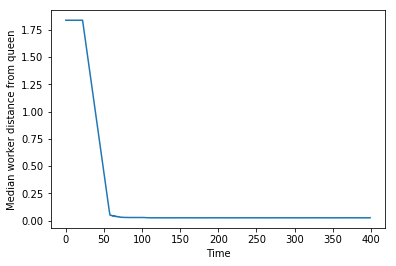

In [66]:
plt.plot(median_distances)
plt.xlabel('Time')
plt.ylabel('Median worker distance from queen')